In [3]:
!pip install tensorflow

Looking in indexes: https://artifactory.dhl.com/artifactory/api/pypi/pypi/simple
  Using cached https://artifactory.dhl.com/artifactory/api/pypi/pypi/packages/packages/e4/8a/0c38f712159d698e6216a4006bc91b31ce9c3412aaeae262b07f02db1174/tensorflow-2.12.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
  Using cached https://artifactory.dhl.com/artifactory/api/pypi/pypi/packages/packages/a1/82/1fd88a2df784dbcfdfba7dbb335653f4178c7c73fa7fe95bae888e60d34b/libclang-16.0.0-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached https://artifactory.dhl.com/artifactory/api/pypi/pypi/packages/packages/d5/80/34e55d7e3ed9cf18020929460f969de1bf82cf2f509c639b358ae2b25618/keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached https://artifactory.dhl.com/artifactory/api/pypi/pypi/packages/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached https://artifactory.dhl.com/artifactory/api/py

In [1]:
import pandas as pd 
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv('/home/jovyan/LSTM/data/SINGAPORE FULL PATHS FEB 23-MAY 23_csv.csv')
df.drop(columns='Unnamed: 0',inplace=True)
df.dropna(inplace=True)
df = df[df['Site Path'].str.contains('en-sg')]
df.reset_index(inplace=True)
df.drop(columns='index',inplace=True)
df.rename(columns={'Unnamed: 3':'Percent'},inplace=True)

In [4]:
df['Site Path'][0]

'Entered Site > EXP$|$/discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > Exited Site'

In [5]:
df['Site Path'] = df['Site Path'].str.replace('EXP\$\|\$', '', regex=True)

In [6]:
df['Site Path'] = df['Site Path'].str.replace('EXP\$\|', '', regex=True)

In [7]:
df['Site Path'][0]

'Entered Site > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > Exited Site'

I am thinking of creating 2 LSTM , one with Entered&Exit and one without

In [8]:
df['count'] = df['Site Path'].str.count('>')

In [9]:
df['count'].value_counts()

8    176
9    140
3     70
4     61
5     37
6     13
7      2
2      1
Name: count, dtype: int64

In [10]:
df['Site Path'] = df['Site Path'].str.replace('Entered Site > ', '', regex=True)

In [11]:
# Add label 1 to sequences that contain 'Thank' keyword

df['label'] = df['Site Path'].str.contains('thank').astype(int)

In [12]:
df['label'].value_counts()
# We have 458 negataive and 42 positive, so roughly 9% positive labels. 

0    458
1     42
Name: label, dtype: int64

In [13]:
df['Site Path'][41]

'/discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9* > /discover/en-sg/offer-services/thank-you$|$Thank you > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > Exited Site'

In [14]:
df['Site Path'][43]

'/discover/en-sg/ship-with-dhl/start-shipping/6-simple-steps-to-start-shipping$|$6 Simple Steps > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > Exited Site'

## data

In [62]:
df

,Site Path,Visits,Percent,count,label
0,"/discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > Exited Site",405,10.2%,2,0
1,"/discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9* > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > Exited Site",335,8.4%,3,0
2,"/discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9* > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > /discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9* > Exited Site",73,1.8%,4,0
3,"/discover/en-sg/offer-go$|$Up to 60% off* on international shipping > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > Exited Site",53,1.3%,3,0
4,"/discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > /discover/en-sg/contact$|$Contact Details - DHL Express Location in Singapore - DHL Express SG > Exited Site",44,1.1%,3,0
...,...,...,...,...,...
495,"/discover/en-sg/ship-with-dhl/start-shipping/advantages-shipping-insurance$|$The Advantages Of > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > /discover/en-sg/ship-with-dhl/start-shipping/advantages-shipping-insurance$|$The Advantages Of > /discover/en-sg/ship-with-dhl/services$|$DHL Services | DHL Solutions | Discover DHL > /discover/en-sg/search-results$|$Search Results - discover.dhl.com - DHL Express > /discover/en-sg/ship-with-dhl/start-shipping/advantages-shipping-insurance$|$The Advantages Of > /discover/en-sg/ship-with-dhl/services/optional-services$|$Optional Services - DHL Express SG > Exited Site",1,0.0%,8,0
496,"/discover/en-sg/ship-with-dhl/start-shipping/advantages-shipping-insurance$|$The Advantages Of > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > /discover/en-sg/ship-with-dhl/start-shipping/advantages-shipping-insurance$|$The Advantages Of > /discover/en-sg/ship-with-dhl/services/optional-services$|$Optional Services - DHL Express SG > /discover/en-sg/ship-with-dhl/start-shipping/advantages-shipping-insurance$|$The Advantages Of > /discover/en-sg/ship-with-dhl/services/optional-services$|$Optional Services - DHL Express SG > /discover/en-sg/ship-with-dhl/start-shipping/advantages-shipping-insurance$|$The Advantages Of > Exited Site",1,0.0%,8,0
497,"/discover/en-au/ship-with-dhl/start-shipping/shipment-preparation$|$Shipment Preparation > /discover/en-us$|$Small business & global logistics advice | Discover DHL USA > /discover/en-us/search-results$|$Search Results - discover.dhl.com - DHL Express > /discover/en-sg/ship-with-dhl/start-shipping/shipment-preparation$|$Shipment Preparation & Onl > /discover/en-sg/ship-now$|$Apply for a DHL Express Account | DHL Express SG > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > /discover/en-sg/register$|$Register for a DHL Account | Discover DHL > Exited Site",1,0.0%,8,0
498,"/discover/en-au/ship-with-dhl/start-shipping/shipment-preparation$|$Shipment Preparation > /discover/en-sg/ship-with-dhl/start-shipping/shipment-preparation$|$Shipment Preparation & Onl > /discover/en-sg/ship-with-dhl$|$Shipping with DHL | Discover DHL > /discover/en-sg/ship-with-dhl/start-shipping/shipment-preparation$|$Shipment Preparation & Onl > /discover/en-sg/ship-with-dhl/start-shipping/packaging-guide$|$Packaging & Box Size Guide – > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > /discover/en-sg/videos$|$Watch Latest Shipping & Logistics Videos | DHL Express Singapore > Exited Site",1,0.0%,8,0


# modeling 

In [137]:
data = list(df['Site Path'])  # your data here
labels = list(df['label'])  # your labels here

In [138]:
tokenizer = Tokenizer(filters='', split=' > ',oov_token='OOV')

In [139]:
tokenizer.fit_on_texts(data)

In [140]:
# Vocabulary
tokenizer.word_index
#OOV words will be ignored / discarded by default, if oov_token is None, LATER when we predict.:

{'OOV': 1,
 '/discover/en-sg$|$dhl express singapore - e-commerce, business, logistics advice': 2,
 'exited site': 3,
 '/discover/en-sg/offer-services$|$super fast delivery across the globe from only $9*': 4,
 '/discover/en-sg/ship-now$|$apply for a dhl express account | dhl express sg': 5,
 '/discover/en-sg.services$|$dhl express singapore - e-commerce, business, logistics advice': 6,
 '/discover/en-sg/digital-base-offer/get-a-quote$|$digital base offer - get a quote': 7,
 '/discover/en-sg/login$|$log in for the latest business & culture news | discover dhl': 8,
 '/discover/en-sg/ship-with-dhl$|$shipping with dhl | discover dhl': 9,
 '/discover/en-sg/search-results$|$search results - discover.dhl.com - dhl express': 10,
 '/discover/en-sg/register$|$register for a dhl account | discover dhl': 11,
 '/discover/en-sg/contact$|$contact details - dhl express location in singapore - dhl express sg': 12,
 '/discover/en-sg/digital-base-offer/get-a-quote/shipment-detail$|$digital base offer - g

In [141]:
sequences = tokenizer.texts_to_sequences(data)

In [142]:
sequences

[[2, 3],
 [4, 2, 3],
 [4, 2, 4, 3],
 [18, 2, 3],
 [2, 12, 3],
 [38, 2, 3],
 [4, 2, 6, 3],
 [16, 2, 3],
 [21, 2, 3],
 [22, 2, 3],
 [4, 2, 16, 3],
 [53, 2, 3],
 [4, 2, 12, 3],
 [18, 2, 18, 3],
 [4, 2, 10, 3],
 [42, 2, 3],
 [2, 16, 3],
 [17, 2, 3],
 [66, 2, 3],
 [2, 5, 3],
 [103, 2, 3],
 [5, 2, 3],
 [12, 2, 3],
 [2, 4, 3],
 [16, 2, 16, 3],
 [4, 7, 2, 3],
 [7, 2, 3],
 [4, 2, 6, 2, 4, 3],
 [66, 2, 66, 3],
 [4, 2, 5, 3],
 [54, 2, 3],
 [73, 2, 3],
 [85, 2, 3],
 [2, 6, 3],
 [2, 32, 3],
 [22, 2, 22, 3],
 [38, 2, 10, 3],
 [2, 10, 3],
 [4, 2, 10, 2, 3],
 [4, 2, 6, 4, 3],
 [4, 2, 6, 2, 3],
 [4, 24, 2, 3],
 [4, 2, 8, 3],
 [55, 2, 3],
 [4, 8, 2, 8, 3],
 [4, 12, 2, 3],
 [2, 12, 2, 3],
 [18, 2, 6, 3],
 [74, 2, 3],
 [2, 39, 3],
 [4, 2, 10, 16, 3],
 [4, 2, 6, 20, 3],
 [21, 27, 2, 3],
 [4, 2, 23, 3],
 [4, 2, 15, 3],
 [12, 2, 12, 3],
 [2, 5, 2, 3],
 [18, 2, 16, 3],
 [17, 2, 17, 3],
 [38, 2, 6, 3],
 [38, 2, 38, 3],
 [104, 2, 3],
 [75, 2, 3],
 [138, 2, 3],
 [14, 2, 3],
 [183, 2, 3],
 [4, 24, 2, 5, 7, 3],
 [

In [143]:
# The tokens which are thank , which we should remove from the sequences. The reason we remove this is because the model is very biased if itt contains this.
# for example,whenever it sees a thank you page it will immediately think its positive, and negative otherwise. But it will not be learning if its like this.
# So we have to remove them, and also remove any integers/urls after those pages too.
thank_tokens = [value for key, value in tokenizer.word_index.items() if 'thank' in key]

In [144]:
def cut_after_thank(sequence, thank_tokens):
    for i in range(len(sequence)):
        if sequence[i] in thank_tokens:
            return sequence[:i+1]
    return sequence

sequences = [cut_after_thank(sequence, thank_tokens) for sequence in sequences]

In [145]:
# Remove the thank you token
sequences = [[token for token in sequence if token not in thank_tokens] for sequence in sequences]

In [146]:
num_unique_urls = len(tokenizer.word_index) + 1  # Add one for padding

In [147]:
max_sequence_len = max([len(seq) for seq in sequences])

In [148]:
sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

In [149]:
sequences[0]

array([0, 0, 0, 0, 0, 0, 0, 2, 3], dtype=int32)

In [150]:
# Remove the last URL 
padded_sequences = np.array([seq[:-1] for seq in sequences])

In [151]:
labels = np.array(labels)

In [152]:
print(sequences.shape)
print(padded_sequences.shape)  # Shape of your input data
print(labels.shape)  # Shape of your labels

(500, 9)
(500, 8)
(500,)


In [153]:
# To decode, you put the numpy array into a list and you see what it is.
tokenizer.sequences_to_texts([sequences[0]])[0]

'OOV OOV OOV OOV OOV OOV OOV /discover/en-sg$|$dhl express singapore - e-commerce, business, logistics advice exited site'

## Creating a Binary Classification LSTM model 
## `Frame the problem as a binary classification task, where the goal is to predict whether a sequence leads to a "lead" page or not.`

In [154]:
# Creating the binary classification model
clf = Sequential()
clf.add(Embedding(input_dim=num_unique_urls, output_dim=10, input_length=max_sequence_len - 1))
clf.add(LSTM(32))
clf.add(Dense(1, activation='sigmoid'))  # Binary classification
clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [155]:
clf.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 8, 10)             2970      
                                                                 
 lstm_4 (LSTM)               (None, 32)                5504      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,507
Trainable params: 8,507
Non-trainable params: 0
_________________________________________________________________


In [156]:
from sklearn.model_selection import train_test_split

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.4, random_state=42, stratify=labels)

# further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)  # 0.25 x 0.8 = 0.2

In [157]:
X_train[:5]

array([[  0,   4,   2,   6,  52,   5,  52,   5],
       [  4,   2,   6,  10,   2,   6,  10,  16],
       [  0,   0,   0,   0,   0,   0,   2,  11],
       [  0,   0,   0,   0,   4,   2,  10,   9],
       [ 49,  36, 204,  36,  49,   2,   5, 153]], dtype=int32)

In [158]:
from keras.callbacks import EarlyStopping
# define early stopping callback
earlystop = EarlyStopping(monitor='val_accuracy', patience=20)

In [159]:
# Train
clf.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_val,y_val),batch_size=8,callbacks=[earlystop])

Epoch 1/100
29/29 [==============================] - 2s 20ms/step - loss: 0.6388 - accuracy: 0.8978 - val_loss: 0.5337 - val_accuracy: 0.9200
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.3844 - accuracy: 0.9156 - val_loss: 0.2662 - val_accuracy: 0.9200
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.2585 - accuracy: 0.9156 - val_loss: 0.2075 - val_accuracy: 0.9200
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 0.2173 - accuracy: 0.9156 - val_loss: 0.1694 - val_accuracy: 0.9200
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 0.1955 - accuracy: 0.9156 - val_loss: 0.1467 - val_accuracy: 0.9200
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.1823 - accuracy: 0.9156 - val_loss: 0.1347 - val_accuracy: 0.9200
Epoch 7/100
29/29 [==============================] - 0s 5ms/step - loss: 0.1708 - accuracy: 0.9156 - val_loss: 0.1267 - val_accuracy: 0.9200
Epoch 8/100


In [160]:
loss, accuracy = clf.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

7/7 [==============================] - 0s 2ms/step - loss: 0.1184 - accuracy: 0.9800
Test Loss: 0.1184116005897522
Test Accuracy: 0.9800000190734863


7/7 [==============================] - 0s 2ms/step
AUC: 0.950


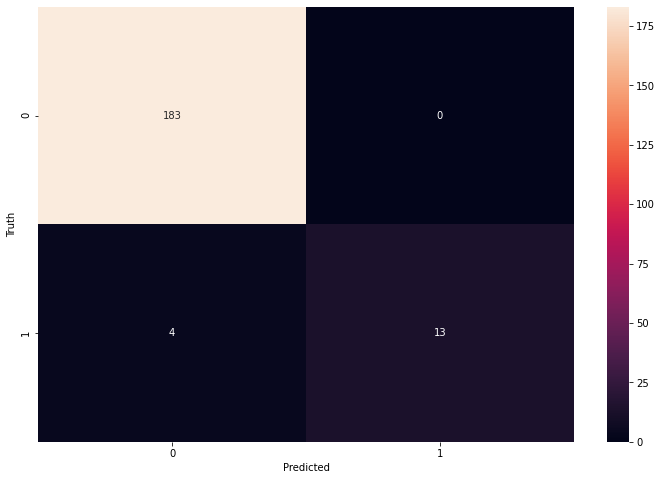

In [161]:
y_pred = clf.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# 3. Calculate the AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)


7/7 [==============================] - 0s 2ms/step


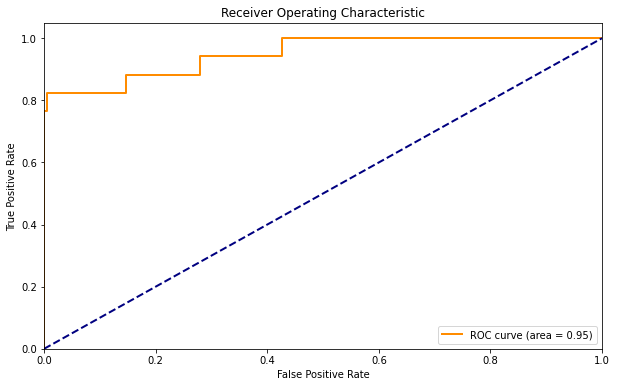

In [162]:
from sklearn.metrics import roc_curve, auc
y_pred = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(10,6))
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Applying the binary clf i.e. given a sequence predict if next URL will be a thank you or not

In [ ]:
# def predict_next_url(model, tokenizer, sequence):
#     token_list = tokenizer.texts_to_sequences([sequence])[0]
#     token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
#     predicted_url_index = model.predict_classes(token_list, verbose=0)[0]
#     for url, index in tokenizer.word_index.items():
#         if index == predicted_url_index:
#             return url


In [36]:
def predict_lead_page(model, tokenizer, sequence):
    token_list = tokenizer.texts_to_sequences([sequence])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len -1, padding='pre')
    prediction = model.predict(token_list, verbose=0)
    return prediction

In [80]:
df.iloc[1]

Site Path    /discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9* > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice > Exited Site
Visits                                                                                                                                                                                        335
Percent                                                                                                                                                                                      8.4%
count                                                                                                                                                                                           3
label                                                                                                                                                                                           0
Name: 1, dtype: object

In [85]:
# define a new sequence for which you want to predict if it leads to a 'thank' page
new_sequence = '/discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9* > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice'

# use the function to predict if the new_sequence leads to a 'thank' page
prediction = predict_lead_page(model, tokenizer, new_sequence)

# print out the prediction
print(f"Probability of lead page: {prediction}")
print(f"Probability of lead page: {prediction[0]}")
print(f"Probability of lead page: {prediction[0][0]}")

if prediction > 0.5:
    print("This sequence is likely to lead to a 'thank' page.")
else:
    print("This sequence is not likely to lead to a 'thank' page.")


Probability of lead page: [[0.27207768]]
Probability of lead page: [0.27207768]
Probability of lead page: 0.27207767963409424
This sequence is not likely to lead to a 'thank' page.


Since you've trained your model on a dataset where 'thank' pages are relatively rare, it might have learned to associate high probability with sequences that are somehow 'unusual' or 'abnormal', because the 'thank' sequences were unusual in the context of the overall training set.

In [82]:
sequences[1]

array([0, 0, 0, 0, 0, 0, 3, 1, 2], dtype=int32)

### To propose pages that could lead to 'thank' pages, you would need to apply a slightly different strategy. One approach is to use a trained model that can predict the next URL, and given a starting sequence, generate sequences by iteratively choosing URLs that are likely to result in a 'thank' page.

In [343]:
def propose_sequence(model, tokenizer, start_sequence, num_steps):
    #give the sequence you want to predict on
    sequence = start_sequence
    for _ in range(num_steps):
        token_list = tokenizer.texts_to_sequences([sequence])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Feed the paddded sequence to model, generate a probability distribution over the 2 possible outcome
        probabilities = model.predict(token_list, verbose=0)[0]
        probabilities_sorted_indexes = np.argsort(probabilities)[::-1]
        for index in probabilities_sorted_indexes:
            proposed_url = ""
            for url, url_index in tokenizer.word_index.items():
                if url_index == index:
                    proposed_url = url
                    break
            if 'thank' in proposed_url:
                sequence += ' > ' + proposed_url
                break
    return sequence

In [347]:
start_sequence = "/discover/en-sg/ship-with-dhl/start-shipping/6-simple-steps-to-start-shipping$|$6 Simple Steps > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice"
num_steps = 5
proposed_sequence = propose_sequence(model, tokenizer, start_sequence, num_steps)
print(proposed_sequence)


/discover/en-sg/ship-with-dhl/start-shipping/6-simple-steps-to-start-shipping$|$6 Simple Steps > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice


In [352]:
start_sequence="discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9* > /discover/en-sg/offer-services/thank-you$|$Thank you > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice"
proposed_sequence = propose_sequence(model, tokenizer, start_sequence, num_steps)
print(proposed_sequence)

discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9* > /discover/en-sg/offer-services/thank-you$|$Thank you > /discover/en-sg$|$DHL Express Singapore - E-commerce, business, logistics advice


# URL Predictor Model

In [163]:
from keras.utils import to_categorical

In [164]:
data = list(df['Site Path'])  # your data here
labels = list(df['label'])  # your labels here
tokenizer = Tokenizer(filters='', split=' > ',oov_token='OOV')
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
num_unique_urls = len(tokenizer.word_index) + 1  # Add one for padding
max_sequence_len = max([len(seq) for seq in sequences])

In [165]:
num_unique_urls,max_sequence_len

(297, 9)

In [166]:
X = []
y = []

for sequence in sequences:
    for i in range(1, len(sequence)):
        X.append(sequence[:i])
        y.append(sequence[i])
        
# Padding the sequences
X = pad_sequences(X, maxlen=max_sequence_len-1, padding='pre')

# one-hot encoding the labels
y = to_categorical(y, num_classes=num_unique_urls)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# defining the model
model = Sequential()
model.add(Embedding(input_dim=num_unique_urls, output_dim=50, input_length=max_sequence_len-1))
model.add(LSTM(100))
model.add(Dense(num_unique_urls, activation='softmax')) # Multiclass classification
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [167]:
# An example of the one hot encoding . It is needed for softmax. 297 elements for a probability for every possible sequence.
y[0],y[0].shape

(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [168]:
X_train[0]

array([ 0,  0,  0, 13,  2,  4,  2, 18], dtype=int32)

In [169]:
hist = model.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/200
73/73 [==============================] - 3s 22ms/step - loss: 4.4634 - accuracy: 0.1918 - val_loss: 3.7822 - val_accuracy: 0.1979
Epoch 2/200
73/73 [==============================] - 0s 7ms/step - loss: 3.7521 - accuracy: 0.2099 - val_loss: 3.7949 - val_accuracy: 0.1945
Epoch 3/200
73/73 [==============================] - 0s 6ms/step - loss: 3.6947 - accuracy: 0.2517 - val_loss: 3.7236 - val_accuracy: 0.2840
Epoch 4/200
73/73 [==============================] - 1s 8ms/step - loss: 3.5557 - accuracy: 0.3009 - val_loss: 3.6106 - val_accuracy: 0.3081
Epoch 5/200
73/73 [==============================] - 1s 7ms/step - loss: 3.4353 - accuracy: 0.3228 - val_loss: 3.5365 - val_accuracy: 0.3201
Epoch 6/200
73/73 [==============================] - 0s 7ms/step - loss: 3.3461 - accuracy: 0.3306 - val_loss: 3.4951 - val_accuracy: 0.3305
Epoch 7/200
73/73 [==============================] - 1s 8ms/step - loss: 3.2782 - accuracy: 0.3345 - val_loss: 3.4852 - val_accuracy: 0.3322
Epoch 8/200


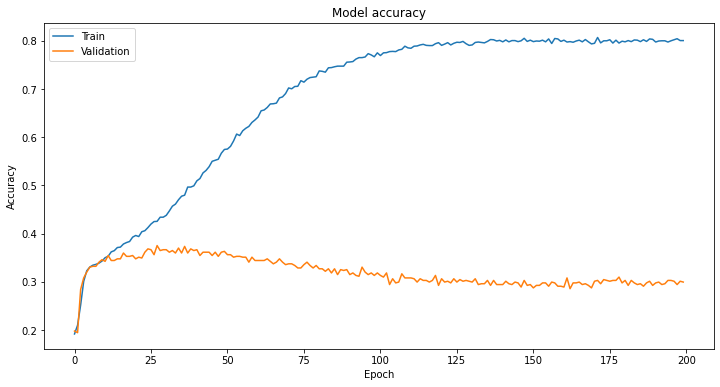

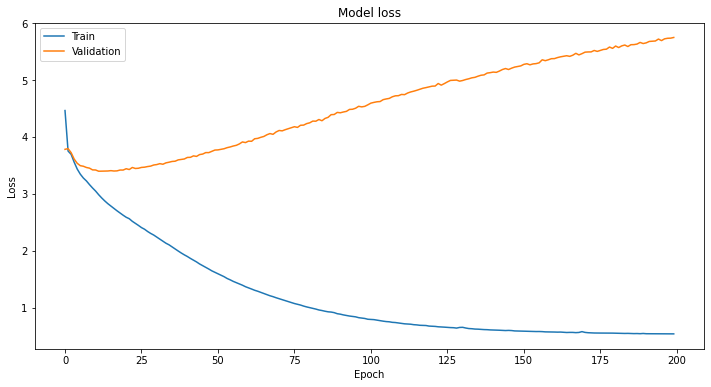

In [170]:
# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [171]:
def predict_next_url(model, tokenizer, sequence):
    token_list = tokenizer.texts_to_sequences([sequence])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    predicted_url_index = model.predict_classes(token_list, verbose=0)[0]
    for url, index in tokenizer.word_index.items():
        if index == predicted_url_index:
            return url

In [172]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

7/7 [==============================] - 0s 2ms/step


In [173]:
y_pred_class

array([  3,   3,   3,   3,   3,   3,   3,   6,   3,   2,   3,  21,   3,
         2,  13,   3,   3,   3,   3,   2,   3,   3,   5,   4,   3,   3,
         3,   3,   2,   2,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,  11,   3,   3,   3,   3,   3,   3,   3,   3,   6,
         3,   3,   3,   3,   2,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   2,   3,   3,   3,   3,   3,   2,   3,   3,   3,   3, 103,
        56,   3,   3,   3,  40,   3,   3,   3,   3,   3,   3,   3,   2,
         9,   3,   3,   3,   3,   2,   3,   3,   3,   3,   3,   3,   3,
         2,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
        30,   2,   5,   3,   3,   3,   3,   3,   3,   3,   3,  18,   3,
         6,   2,   3,   3,   3,   3,   3,   2,   3,   3,   3,   3,   3,
         3,   5,   3,   3,   3,   3,   3,   2,   3,   3,   3,   3,  14,
         3,   3,   3,   2,   3,   3,   3,   3,   3,   2,   3,  31,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   

In [174]:
tokenizer.sequences_to_texts([[3]])

['exited site']

In [175]:
def predict_next_url(model, tokenizer, sequence):
    """
    To use the function predict_next_url, you need to provide a sequence of URLs. 
    This sequence should be in the same format as the sequences you used to train your model. Here is an example: X > A > Exited Site
    """
    token_list = tokenizer.texts_to_sequences([sequence])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len -1, padding='pre')
    prediction = model.predict(token_list, verbose=0)
    predicted_index = np.argmax(prediction, axis=-1)
    predicted_url = ""
    for url, url_index in tokenizer.word_index.items():
        if url_index == predicted_index:
            predicted_url = url
            break
    return predicted_url

import heapq

def predict_next_n_urls(model, tokenizer, sequence, n):
    """
    To use the function predict_next_url, you need to provide a sequence of URLs. 
    This sequence should be in the same format as the sequences you used to train your model. Here is an example: X > A > Exited Site
    """
    token_list = tokenizer.texts_to_sequences([sequence])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len -1, padding='pre')
    prediction = model.predict(token_list, verbose=0)[0]
    top_n_indices = heapq.nlargest(n, range(len(prediction)), prediction.take)
    top_n_urls = []
    for url, url_index in tokenizer.word_index.items():
        if url_index in top_n_indices:
            top_n_urls.append((url, prediction[url_index]))
    return top_n_urls


In [176]:
predict_next_url(model,tokenizer,'/discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9*')

'/discover/en-sg$|$dhl express singapore - e-commerce, business, logistics advice'

In [177]:
predict_next_n_urls(model,tokenizer,'/discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9*',3)

[('/discover/en-sg$|$dhl express singapore - e-commerce, business, logistics advice',
  0.582124),
 ('/discover/en-sg/digital-base-offer/get-a-quote$|$digital base offer - get a quote',
  0.10778472),
 ('/discover/en-sg/offer-services/thank-you$|$thank you', 0.09364132)]

# Combining the 2 models. Method : 
- Output the top 3 URL from the sequence URL prediction model
- Pass those sequences to the Binary Classification model (predict if next seq will be thank you or not)
- Return results

In [194]:
def predict_next_url_combined(predictor_model, classifier_model, tokenizer, sequence, n_results=5):
    """
    This function uses the next-URL prediction model to create a probability distribution of all the possible next URL. It ranks them on probability.
    Then, for each of the next-possible-URL , we concatenate it into the base sequence which we gave as input and pass it through the classification model, which outputs probability of the next page being a thank you.
    We multiply the probability of the binary clssification with the the next-url probability(for now with no weights on each). We rank those on highest, and print the n_results many we want.
    The probability that we see in the end so is the multiplication of the 2 previous probabilities described, next url in general and also thank you page probability.
    """
    # Extract the URL from the sequence tuple
    sequence = sequence[0]

    # Get the next URL probabilities from the sequence predictor
    token_list = tokenizer.texts_to_sequences([sequence])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len -1, padding='pre')
    predictor_probs = predictor_model.predict(token_list, verbose=0)[0]

    # Get the classification probabilities for each URL
    classifier_probs = np.zeros_like(predictor_probs)
    for url, url_index in tokenizer.word_index.items():
        extended_sequence = sequence + ' > ' + url
        token_list = tokenizer.texts_to_sequences([extended_sequence])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        classifier_probs[url_index-1] = classifier_model.predict(token_list, verbose=0)[0]

    # Combine the probabilities by a simple multiplication, we can also add weight here
    combined_probs = predictor_probs * classifier_probs

    # Return the top n URLS with the highest combined probability
    top_n_indexes = np.argsort(combined_probs)[-n_results:][::-1]

    predicted_urls_probs = []
    for predicted_index in top_n_indexes:
        predicted_url = ""
        for url, url_index in tokenizer.word_index.items():
            if url_index - 1 == predicted_index:
                predicted_url = url
                break
        predicted_urls_probs.append((sequence + ' > ' + predicted_url, combined_probs[predicted_index]))

    return predicted_urls_probs

In [195]:
predict_next_url_combined(model,clf,tokenizer,'/discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9*')

[('/ > exited site', 0.5477171),
 ('/ > /discover/en-sg/news/shipping-healthcare-supplies-to-mainland-china$|$shipping healthcare supp',
  0.107300326),
 ('/ > /discover/en-sg/offer-services/thank-you$|$thank you', 0.062964275),
 ('/ > /discover/en-sg/ship-with-dhl/services/on-demand-delivery$|$on-demand delivery and flexible al',
  0.034426045),
 ('/ > /discover/en-sg/ship-with-dhl/start-shipping/on-demand-delivery-options$|$on-demand delivery o',
  0.021368735)]

In [199]:
sequences = predict_next_n_urls(model, tokenizer, '/discover/en-sg/offer-services$|$Super fast delivery across the globe from only $9*', 3)
print('For our given sequence, these are the 3 most probable sequences. For each of the 3, the model provides 5 most promising URL that lead to a thank you page along with the confidence\n')
for sequence in sequences:
    pprint(predict_next_url_combined(model, clf, tokenizer, sequence))
    print('\n')

For our given sequence, these are the 3 most probable sequences. For each of the 3, the model provides 5 most promising URL that lead to a thank you page along with the confidence

[('/discover/en-sg$|$dhl express singapore - e-commerce, business, logistics '
  'advice > /discover/en-sg/register$|$register for a dhl account | discover '
  'dhl',
  0.017900007),
 ('/discover/en-sg$|$dhl express singapore - e-commerce, business, logistics '
  'advice > /discover/en-sg/offer-services$|$super fast delivery across the '
  'globe from only $9*',
  0.0056072865),
 ('/discover/en-sg$|$dhl express singapore - e-commerce, business, logistics '
  'advice > /discover/en-sg/digital-base-offer/get-a-quote$|$digital base '
  'offer - get a quote',
  0.004902206),
 ('/discover/en-sg$|$dhl express singapore - e-commerce, business, logistics '
  'advice > /discover/en-sg/offer-services/thank-you$|$thank you',
  0.0046858406),
 ('/discover/en-sg$|$dhl express singapore - e-commerce, business, logistics '